In [23]:

# a = "/home/s2765918/code-et/results/HRC/test_early_and_late_fusions_new/models/test_early_and_late_fusions_new_fold_2.pt"

In [1]:
import pickle
import numpy as np
import torch
from torch import nn

/home/s2765918/miniconda3/envs/copy_of_open-mmlab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
byt= pickle.load(open("/home/s2765918/code-et/code/npy_data/sorted_data_fullframes/test_all_20_vit16_new_with_idx.npy_sorted.npy","rb"))

UnpicklingError: STACK_GLOBAL requires str

In [ ]:
byt[0]

In [79]:
torch.tensor(test[:20]).unsqueeze(0).view(-1,1,768).size()

torch.Size([20, 1, 768])

In [41]:
m = nn.Conv1d(768, 64, 10, stride=2)

In [76]:
torch.tensor(test[:20]).unsqueeze(0).view(-1,1,768).size()

torch.Size([20, 1, 768])

In [80]:
reshaped_input = torch.tensor(test[:20]).unsqueeze(0).view(-1,1,768)
print(reshaped_input.shape)
# Define the convolutional layer
print(reshaped_input.shape)
conv = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1)

global_avgpool = nn.AdaptiveAvgPool1d(1)
# maxpool = nn.MaxPool1d(5, 5)
# Apply the convolution
output = conv(reshaped_input)
print("global" ,global_avgpool(output).size())

torch.Size([20, 1, 768])
torch.Size([20, 1, 768])
global torch.Size([20, 64, 1])


In [82]:
global_avgpool(output).squeeze(2).size()

torch.Size([20, 64])

In [65]:
print(conv.weight.shape)

torch.Size([64, 1, 5])


In [61]:
print(output.shape)

torch.Size([1, 64, 766])


In [ ]:
m(torch.from_numpy(test[0]).unsqueeze(0).unsqueeze(0))

In [19]:
fusion =nn.Conv2d(768, 64, (5,5), stride=1, padding=0, 
                                dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [ ]:
test[0]

In [20]:
fusion(test[0])

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [3]:
test = np.load("/home/s2765918/code-et/code/npy_data/sorted_data_fullframes/test_all_20_vit16_new_with_idx.npy_sorted.npy",allow_pickle=True)

In [95]:
test.shape

(844268, 768)

In [ ]:

test[1000]

In [ ]:
print(test[0])

In [3]:
f =np.stack(list(map(lambda x:x[1],byt)))

In [15]:
f.shape

(3493623, 768)

In [ ]:
f[-1]

In [4]:
f.shape

(3493623, 768)

In [5]:
np.save("/home/s2765918/code-et/code/npy_data/train_all_20_vit16_new_with_idx_sorted.npy",f)

In [ ]:
del byt

In [ ]:
f[0]

In [7]:
f = np.concatenate(list(map(lambda x:x[1],byt)))

In [15]:
f[:1000]

array([[-0.24879941, -0.00329586,  0.1051245 , ..., -0.43561324,
         1.5423084 , -0.22294894],
       [-0.23017389, -0.02932646,  0.12077133, ..., -0.43193483,
         1.5507529 , -0.21978539],
       [-0.07027504,  0.5964884 ,  0.29185128, ..., -0.37085715,
         1.5515088 , -0.18744203],
       ...,
       [-0.25750735, -0.12463307,  0.23786296, ...,  1.6564834 ,
         1.1204059 , -0.29390565],
       [-0.2719468 , -0.09873871,  0.256667  , ...,  1.6542456 ,
         1.1079212 , -0.31651527],
       [-0.24102627, -0.24518178,  0.16014503, ...,  1.5475044 ,
         1.076938  , -0.38254213]], dtype=float32)

In [ ]:
np.save("/home/s2765918/code-et/code/npy_data/test_all_20_vit16_new_with_idx_sorted.npy",f)

In [2]:
from vit import VisionTransformer
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
import torch
from matplotlib import pyplot as plt
import cv2
from torch import nn
from torchvision import transforms 
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
from trajectory import Trajectory, TrajectoryDataset, extract_fixed_sized_segments, split_into_train_and_test, remove_short_trajectories, get_categories, get_UTK_categories, get_NTU_categories,extract_frames
import pickle
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from einops import rearrange, repeat

from transformer import TubeletTemporalSpatialPart_concat_chan_2_Transformer, \
                TubeletTemporalPart_concat_chan_1_Transformer, TubeletTemporalTransformer, \
                TubeletTemporalPart_mean_chan_1_Transformer, TubeletTemporalPart_mean_chan_2_Transformer,\
                 TubeletTemporalPart_concat_chan_2_Transformer, TemporalTransformer_4, \
                 TemporalTransformer_3, TemporalTransformer_2, BodyPartTransformer, \
                 SpatialTemporalTransformer, TemporalTransformer, Block, Attention, Mlp, ensemble,vit_model

KeyboardInterrupt: 

In [ ]:


#Load test trajectories
PIK = "/home/s2765918/code-et/code/data/HRC/trajectories_test_HRC_2D.dat"


with open(PIK, "rb") as f:
    trajectories = pickle.load(f)

Taking a sample of the data

In [16]:
train_size =0.005
test_size=0.005
train_crime_trajectories_new ={}
test_crime_trajectories_new = {}
idx_filemap = {i:k for i,k in enumerate(trajectories)}
splitter = StratifiedShuffleSplit(n_splits=1,train_size=train_size,test_size=test_size,random_state=1)

all_labels = [v.category for k,v in trajectories.items()]
split_labels_train = []
split_labels_test = []
for x,y in splitter.split(trajectories,all_labels):
    for i in x:
        train_crime_trajectories_new[idx_filemap[i]] = trajectories[idx_filemap[i]]
        # split_labels_train.append(all_labels[i])

    for j in y:
        test_crime_trajectories_new[idx_filemap[j]] = trajectories[idx_filemap[j]]
        # split_labels_test.append(all_labels[j])

train_crime_trajectories = train_crime_trajectories_new

test_crime_trajectories = test_crime_trajectories_new

In [ ]:
def getVideoPath(ids,path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos"):
    # print(ids)
    getVideoFiles = ids
    file = getVideoFiles.split("_")[0]
    
    videoDir = file[:-3] 

    videofile = file +"_x264.mp4"

    video_path = os.path.join(path,videoDir,videofile)

    return video_path

class TrajectoryDataset_(Dataset):
    """
    A dataset to store the trajectories. This should be more efficient than using just arrays.
    Also should be efficient with dataloaders.
    """
    def __init__(self, trajectory_ids, trajectory_videos, trajectory_persons, trajectory_frames, trajectory_categories, X,vit_frames=None):
        self.ids = trajectory_ids.tolist()
        print("list of ids")
        print(len(self.ids))
        self.videos = trajectory_videos.tolist()
        self.persons = trajectory_persons.tolist()
        self.frames = trajectory_frames
        self.categories = trajectory_categories
        self.coordinates = X
        self.vit_frames = vit_frames
        self.path = [getVideoPath(i[0]) for i in self.ids]
        print("Loaded paths and stuffs")
 
    def __len__(self):
        return len(self.ids)

    def extract_frames(self,idx,frame_list,path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos"):
        


        cap = cv2.VideoCapture(self.path[idx]) 

        middle_frame = frame_list[len(frame_list)//2].item()
        
        cap.set(1,middle_frame) 

        ret, frame = cap.read()
        dim = (224,224)

        resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

        # frame = rearrange(resized,"h w c -> c h w")
        return frame/255.0
        # return torch.from_numpy(resized)/255.0

    def __getitem__(self, idx):
        data = {}
        data['id'] = self.ids[idx] #contains all the videos
        
        data['videos'] = self.videos[idx]
        
        data['persons'] = self.persons[idx]
        data['frames'] = self.frames[idx]
        data['categories'] = self.categories[idx]
        data['coordinates'] = self.coordinates[idx]
        data['path'] = self.path[idx]
        
        # data['context'] = self.context[idx]
        # print("Extracted frames time ")
        # start = time.time()
        # data['extracted_frames'] = self.extract_frames(idx,self.frames[idx])
        data['extracted_frames'] = torch.from_numpy(np.array(self.vit_frames[idx]))
        # data['extracted_frames'] = self.context_frames[idx]
        # print(f"Extracted frames : {abs(start-time.time())}")
        return data
        # return self.ids[idx], self.videos[idx], self.persons[idx], self.frames[idx],self.coordinates[idx], self.categories[idx]

    def trajectory_ids(self):
        return self.ids


In [ ]:
test = np.load("/home/s2765918/code-et/code/npy_data/sorted_data_fullframes/train_all_20_vit16_new_with_idx.npy_sorted.npy")

In [ ]:
# train_crime_trajectories = remove_short_trajectories(trajectories, input_length=20, input_gap=0, pred_length=0)
test_crime_trajectories = remove_short_trajectories(trajectories, input_length=20, input_gap=0, pred_length=0)

In [ ]:
# train = TrajectoryDataset(*extract_fixed_sized_segments("HRC", train_crime_trajectories, input_length=20))
test_dataset = TrajectoryDataset_(*extract_fixed_sized_segments("HRC", test_crime_trajectories, input_length=20),vit_frames=test)

list of ids
844268
Loaded paths and stuffs


<h3>Cross attention new attempt</h3>

In [15]:
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,return_attention=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor can be manually set to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.cross_attn_scores = None

        self.project_skeleton = nn.Linear(dim,dim)
        self.project_context_key = nn.Linear(dim,dim)
        self.project_context_value = nn.Linear(dim,dim)
        
    def forward(self, encoder_1,encoder_2): 
        #encoder_1 skeleton trajectories, encoder_2 visual information
        #value = output of model which contains skeleton trajectories, #query and key model which consists of spatial information
        # print(encoder_1.shape)
        # print(encoder_2.shape)
        B, N,C = encoder_1.shape #Batch, segment length, embed dim
        
        q, k, v = encoder_1, encoder_2, encoder_2   # make torchscript happy (cannot use tensor as tuple)
        #torch.Size([1, 100, 64])
        # print("block")
        # print("Input 1 ",encoder_1)
        # print("Input 2 ",encoder_2)
        q = self.project_skeleton(q).reshape(B,N,self.num_heads,C//self.num_heads).permute(0,2,1,3) #batch,segment length, num_heads,embed dim/num_head
        # project= self.project_skeleton(q)
        # print(q.size())

        k = self.project_context_key(k).reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3) #same
        v = self.project_context_value(v).reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3)
        # print(k)
        print(q.size())
        print(v.size())
        # print("reshapoed key ", k.size())
        # print(q.size())
        # B,N,C = encoder_2.shape
        # print(v.size())
        # v = v.squeeze()

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [100, 4, 21, 1]) [100, 4, segment legnth, 1 for each context]) 
        # print(q@k.transpose(-2,-1))
        attn = attn.softmax(dim=-2)
        # print(attn.size())
        print("attn")
        print(attn)
        attn = self.attn_drop(attn)

        self.cross_attn_scores = attn
        print((attn@v).size())
        x = (attn @ v).reshape(B, N, C)
        print(x.size())
            
        x = self.proj(x)
        print("Final input")
        print(x.size())

        x = self.proj_drop(x)

        return x

class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 dropout=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = CrossAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        #self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.dropout = nn.Dropout(dropout) #first try a simple dropout instead of drop path
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
    def forward(self, encoder_1,encoder_2):
        #architecture taken from these paper https://arxiv.org/pdf/2204.04564.pdf

        x = self.dropout(self.attn(encoder_1,encoder_2))
        print(encoder_2.size())
        # print(x.size())
        # print(x.permute(1,0,2).size())
        # x = self.norm2(encoder_2.permute(1,0,2)+x)
        x = self.mlp(x)
        return x
    

In [295]:
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,return_attention=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor can be manually set to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.cross_attn_scores = None

        self.project_skeleton = nn.Linear(dim,dim)
        self.project_context_key = nn.Linear(dim,dim)
        self.project_context_value = nn.Linear(dim,dim)
        
    def forward(self, encoder_1,encoder_2): 
        # print(encoder_1.shape)
        # print(encoder_2.shape)

        B, N,C = encoder_1.shape #Batch, segment length, embed dim
        # print(B,N,C)
        q, k, v = encoder_1, encoder_2, encoder_2   # make torchscript happy (cannot use tensor as tuple)

        q = self.project_skeleton(q).reshape(B,N,self.num_heads,C//self.num_heads).permute(0,2,1,3) #batch,segment length, num_heads,embed dim/num_head
        k = self.project_context_key(k).reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3) #same
        # print(f"Query : {q.shape} ")
        # print(f"Key : {k.shape} ")
        attention = q@k.transpose(-2,-1)
        attention_weights = nn.Softmax(dim=2)(attention)
        self.cross_attn_scores=attention_weights
        # print(attention_weights.size())
        v = self.project_context_value(v).reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3)
        final = (attention_weights@v).reshape(B, N, C)

        return final
        # print(final.size())
        # print(k)
        # return
class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 dropout=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = CrossAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        #self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.dropout = nn.Dropout(dropout) #first try a simple dropout instead of drop path
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
    def forward(self, encoder_1,encoder_2):
        #architecture taken from these paper https://arxiv.org/pdf/2204.04564.pdf

        x = self.dropout(self.attn(encoder_1,encoder_2))

        x = self.norm2(encoder_1+x)
        x = self.mlp(x)
        return x

In [340]:

class TemporalTransformer_CrossAttention(TemporalTransformer):
    def __init__(self, *args,**kwargs):
        """    ##########hybrid_backbone=None, representation_size=None,
        Args:
            num_classes (int): number of classes for classification head, HR-Crime constists of 13 crime categories
            num_frames (int): number of input frames
            num_joints (int): number of joints per skeleton
            in_chans (int): number of input channels, 2D joints have 2 channels: (x,y)
            embed_dim_ratio (int): embedding dimension ratio
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
        """
        super().__init__(*args, **kwargs)

        # self.embedding = nn.Linear(num_joints*in_chans, embed_dim//2)

        self.align_dimension = nn.Linear(768,kwargs["embed_dim"]) # this is for the frames
        self.head = nn.Linear(kwargs["embed_dim"],kwargs["num_classes"])
        # self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+2, kwargs["embed_dim"]))
        # initialize weights
        self.init_weights()
        self.conv_1d= nn.Conv1d(in_channels=1, out_channels=kwargs["embed_dim"], kernel_size=5, stride=1)
        self.global_avgpool = nn.AdaptiveAvgPool1d(1)
        self.cross_attention_block = nn.ModuleList([
            CrossAttentionBlock(
                dim=64, num_heads=4
                 #drop_path=dpr[i] #first try a simple dropout instead of drop path
                )
            for i in range(4)])
        # taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    def init_weights(self):
          initrange = 0.1
          self.embedding.weight.data.uniform_(-initrange, initrange)
          self.head.bias.data.zero_()
          self.head.weight.data.uniform_(-initrange, initrange)

    def forward_features(self, x):

        #print("call forward features")
        # print(f"x shape: {x.shape}")

        x = self.embedding(x)

        #print(f"self cls_token shape: {self.cls_token.shape}")

        #print("expand cls_token")
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        # print(f"Cls token {cls_token.shape}")
        #print(f"expanded cls_token shape: {cls_token.shape}")
        #print(f"embedded x shape: {x.shape}")

        x = torch.cat((cls_token, x), dim=1)
        # print(x.shape)
        #print(f"embedded x + cls_token shape: {x.shape}")

        #print(f"pos_embed shape: {self.pos_embed.shape}")
        #print(f"x + self.pos_embed shape: {(x + self.pos_embed).shape}")

        x = self.pos_drop(x + self.pos_embed)
        # print(f"pos_drop x shape: {x.shape}")

        #x = self.blocks(x)
        for blk in self.blocks:
            x = blk(x)
            #print(f"blocks(x) shape: {x.shape}")

        x = self.norm(x)

        return x
    

    def forward(self, x,frames):
        x = self.forward_features(x)

        frames = self.align_dimension(frames)
        
        for i in self.cross_attention_block:
            x = i(x,frames)
        x = x[:,0] #clst token
        x = self.head(x)
        print(x.size())
        x = F.log_softmax(x, dim=1)
        return x

In [341]:
model = TemporalTransformer_CrossAttention(num_classes=19, num_frames=20, num_joints=17, in_chans=2, embed_dim=64, depth=2,
                 num_heads=4, mlp_ratio=2., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., dropout=0.2)

num_classes 19
embed_dim 64
in_chans 2
num_joints 17
num_heads 4
depth 2


In [342]:
model(torch.randn(500,20,34),torch.randn(500,768))

torch.Size([500, 19])


tensor([[-3.0814, -2.9139, -2.8469,  ..., -2.8982, -2.9196, -3.0224],
        [-3.1191, -2.8805, -2.8374,  ..., -2.8707, -2.8536, -3.0249],
        [-3.1212, -2.8343, -2.8478,  ..., -2.9123, -2.8721, -2.9305],
        ...,
        [-3.0167, -2.8011, -2.8016,  ..., -2.9189, -2.8050, -3.0275],
        [-3.0731, -2.8407, -2.8081,  ..., -2.9612, -2.8783, -3.0218],
        [-3.1204, -3.0312, -2.9572,  ..., -2.8484, -2.9272, -2.9922]],
       grad_fn=<LogSoftmaxBackward0>)

In [310]:
f = nn.ModuleList([
            CrossAttentionBlock(
                dim=64, num_heads=4
                 #drop_path=dpr[i] #first try a simple dropout instead of drop path
                )
            for i in range(4)])

In [292]:
f[0].attn.cross_attn_scores[0][1][:]

TypeError: 'NoneType' object is not subscriptable

In [293]:
torch.randn(20,64).transpose(1,0).size()

torch.Size([64, 20])

In [294]:
x = a
for i in f:
    x = i(x,b)


torch.Size([20, 21, 64])
torch.Size([20, 64])
torch.Size([20, 21, 64])
torch.Size([20, 64])
torch.Size([20, 21, 64])
torch.Size([20, 64])
torch.Size([20, 21, 64])
torch.Size([20, 64])


In [207]:
ca = CrossAttention(dim=64)

In [ ]:
ca(a,b)

In [16]:
model = TemporalTransformer(num_classes=19, num_frames=20, num_joints=17, in_chans=2, embed_dim=64, depth=4,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., dropout=0.2)

num_classes 19
embed_dim 64
in_chans 2
num_joints 17
num_heads 8
depth 4


In [153]:
a = torch.randn(20,21,64) #(1,64) represents the seggregation of all 20 classes
b = torch.randn(20,64) #(1,64 represents the 1 context for the 20 segments)

In [99]:
c = a@b

In [100]:
c.size()
#20 21 1
#20 64 1
#20 1 64

torch.Size([20, 21, 1])

In [130]:
f = (c@b.transpose(-2,-1))

In [131]:
f

tensor([[[ 8.5192e+00,  8.2383e+00, -3.3091e+00,  ..., -8.8994e+00,
           1.1887e+01,  5.0799e+00],
         [ 1.1564e+01,  1.1183e+01, -4.4919e+00,  ..., -1.2080e+01,
           1.6135e+01,  6.8956e+00],
         [ 6.8365e+00,  6.6110e+00, -2.6555e+00,  ..., -7.1416e+00,
           9.5388e+00,  4.0765e+00],
         ...,
         [-8.1752e+00, -7.9055e+00,  3.1755e+00,  ...,  8.5400e+00,
          -1.1407e+01, -4.8747e+00],
         [-2.9915e+00, -2.8928e+00,  1.1620e+00,  ...,  3.1250e+00,
          -4.1739e+00, -1.7838e+00],
         [ 7.0828e+00,  6.8492e+00, -2.7512e+00,  ..., -7.3989e+00,
           9.8826e+00,  4.2234e+00]],

        [[-8.9758e-02, -6.1805e-01,  8.3288e-01,  ...,  9.8795e-01,
           6.7435e-01, -3.8374e-01],
         [-5.9575e-01, -4.1022e+00,  5.5281e+00,  ...,  6.5573e+00,
           4.4759e+00, -2.5470e+00],
         [-1.3479e+00, -9.2811e+00,  1.2507e+01,  ...,  1.4836e+01,
           1.0127e+01, -5.7624e+00],
         ...,
         [-4.0165e-01, -2

In [125]:
c@b.transpose

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [20, 21] but got: [20, 64].

In [117]:
f = nn.Softmax(dim=0)(c)

In [119]:
sum(f[:,0])

tensor([1.])

In [85]:
c = torch.tensor([[2,4,5,6],[0.2,0.4,0.5,0.6]]).type(torch.float32)

In [88]:
c.size()

torch.Size([2, 4])

In [90]:
0.2*2+0.4*3+0.5*4+0.6*5

6.6

In [86]:
d= torch.tensor([
    [
        [2,3,4,5]
    ],
    [
        [6,7,8,9]
    ]
    
    ]).type(torch.float32)

In [89]:
d.size()

torch.Size([2, 1, 4])

In [82]:
d.size()

torch.Size([2, 1, 4])

In [87]:
c@d.transpose(-2,-1)

tensor([[[ 66.0000],
         [  6.6000]],

        [[134.0000],
         [ 13.4000]]])

In [71]:
d.size()

torch.Size([2, 1, 4])

In [67]:
c.size()

torch.Size([2, 4])

In [63]:
b[1]

tensor([[ 0.2936],
        [-1.0285],
        [-1.6604],
        [ 0.5180],
        [-1.2044],
        [ 0.1061],
        [-1.4130],
        [ 0.2588],
        [-1.4097],
        [ 0.4880],
        [-0.0969],
        [ 1.1634],
        [ 0.2997],
        [-0.6680],
        [ 0.2746],
        [ 0.7753],
        [ 1.5403],
        [-0.4601],
        [ 0.0544],
        [-0.0287],
        [ 0.0854],
        [ 0.7628],
        [ 0.3447],
        [ 0.6424],
        [ 0.3818],
        [-1.5433],
        [ 0.0757],
        [ 0.6480],
        [-0.7284],
        [-0.3601],
        [-0.6810],
        [ 0.0406],
        [ 0.0980],
        [-0.1506],
        [-1.1781],
        [-2.5565],
        [-0.0816],
        [-1.5920],
        [-0.4924],
        [-0.0169],
        [ 1.6030],
        [ 0.9204],
        [-0.0266],
        [-0.8673],
        [ 0.5866],
        [-0.1926],
        [ 0.1956],
        [-1.7585],
        [ 0.7227],
        [-1.6749],
        [-1.5131],
        [ 0.7692],
        [ 2.

In [61]:
a@b.transpose(-2,-1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1280x1 and 64x20)

In [56]:
# c = b.view(-1,64,20)

In [57]:
c.size()

torch.Size([1, 64, 20])

In [54]:
attend = a@b

In [55]:
attend.size()

torch.Size([20, 20, 1])

In [34]:
attend.size()

torch.Size([20, 1, 1, 20, 1])

In [19]:
model(torch.randn(1,20,34))

tensor([[-3.7566, -2.9847, -2.7808, -3.4429, -3.2399, -2.9345, -2.5696, -3.2237,
         -3.0759, -2.9272, -3.1139, -2.1889, -2.9753, -2.2435, -3.3873, -2.7175,
         -3.2055, -3.8290, -3.0360]], grad_fn=<LogSoftmaxBackward0>)

In [44]:
#200 idx has bugs
#.75 * width, 1.25 height ->  50500 41200

<h3>Alignment of coordinates and visualizing its scale factors for context</h3>

Have to fix 0 division error or nonetype error. 
- What is it?

In [12]:
import random
from matplotlib import pyplot as plt



In [45]:
def expandbounding(coords,height_expand=0.5,width_expand=0.5,img_resize=50):
    #Expanding the bounding box
    rx = img_resize/240 #ratio to resize
    ry = img_resize/320 #ration to resize
    x_values = coords[1::2]
    y_values = coords[2::2]

    startcoord_x = int(min(x_values))
    startcoord_y = int(min(y_values))

    #Multiply with the ratio for cooridnate alignment
    x_values_ = coords[1::2]*ry
    y_values_ = coords[1::2]*rx

    # endcoord_x = int(max(x_values))
    # endcoord_x = int(max(y_values))

    startcoord_x_ = int(min(x_values_))
    startcoord_y_ = int(min(y_values))


    endcoord_x_ = int(max(x_values))
    endcoord_y_ = int(max(y_values))

    width = endcoord_x_ - startcoord_x
    height = endcoord_y_ - startcoord_y_



    expansion_width = width_expand * width
    expansion_height =height_expand * height

    print(expansion_width)
    print(expansion_height)

    # expanded_x_min =  int(startcoord_x - expansion_width)
    # expanded_y_min = int(startcoord_y- expansion_height)
    # expanded_x_max = int(endcoord_x + expansion_width)
    # expanded_y_max = int(endcoord_y + expansion_height)

    expanded_x_min = int(max(0, startcoord_x_ - expansion_width))
    expanded_y_min = int(max(0, startcoord_y_ - expansion_height))
    expanded_x_max = int(min(endcoord_x_ + expansion_width, img_resize))
    expanded_y_max = int(min(endcoord_y_ + expansion_height, img_resize))

    return expanded_x_min,expanded_y_min,expanded_x_max,expanded_y_max,\
            startcoord_x_,startcoord_y_,endcoord_x_,endcoord_y_


In [57]:
def samplerandom(dataset,n_rows=5,height_expand=0.5,width_expand=0.5,img_resize=25):
    sample_ix= random.sample(range(1, len(dataset)), n_rows) #number of rows
    
    print(sample_ix)
    
    fig, axs = plt.subplots(n_rows, 3, figsize=(12, 3*n_rows))
    # coords = dataset[idx]["coordinates"][len(dataset[idx]["coordinates"])//2]
    # x_min,y_min,x_max,y_max = expandbounding(coords,height_expand=0.8,width_expand=0.8)
    for index,rows in enumerate(axs):
        print(index)
    
        coords = dataset[sample_ix[index]]["coordinates"][len(dataset[sample_ix[index]]["coordinates"])//2]
        
        img = dataset[sample_ix[index]]["extracted_frames"]
        img = cv2.resize(img,(img_resize,img_resize))
        print(img.shape)
        ex_min,ey_min,ex_max,ey_max, x_min,y_min,x_max,y_max = expandbounding(coords,height_expand=height_expand,width_expand=width_expand,img_resize=50)
        
        for index_column,_ in enumerate(rows):
            if index_column==0:
                axs[index][index_column].imshow(img)
                axs[index][index_column].set_title(f"Orginal Frame idx : {sample_ix[index_column]}")
            elif index_column==1:
                # axs.plot(img[])
                print(img[y_min:y_min+y_max, x_min:x_min+x_max].shape)
                # axs.plot(img[y_min:y_min+y_max, x_min:x_min+x_max])
                axs[index][index_column].imshow(img[y_min:y_min+y_max, x_min:x_min+x_max])
                axs[index][index_column].set_title(f"Just alignment(from original)")
            else:
                print(img[ey_min:ey_max ,ex_min:ex_max].shape)
                axs[index][index_column].imshow(img[ey_min:ey_max ,ex_min:ex_max])
                # axs[index][index_column].plot(img[ey_min:ey_max ,ex_min:ex_max])
                axs[index][index_column].set_title(f"Expanded w={width_expand} h={height_expand} ")

[526080, 689123, 471475, 229262, 543729, 526835, 712870, 684327, 628162, 100265]
0
(100, 100, 3)
15.0
11.0
(34, 90, 3)
(0, 50, 3)


ValueError: zero-size array to reduction operation minimum which has no identity

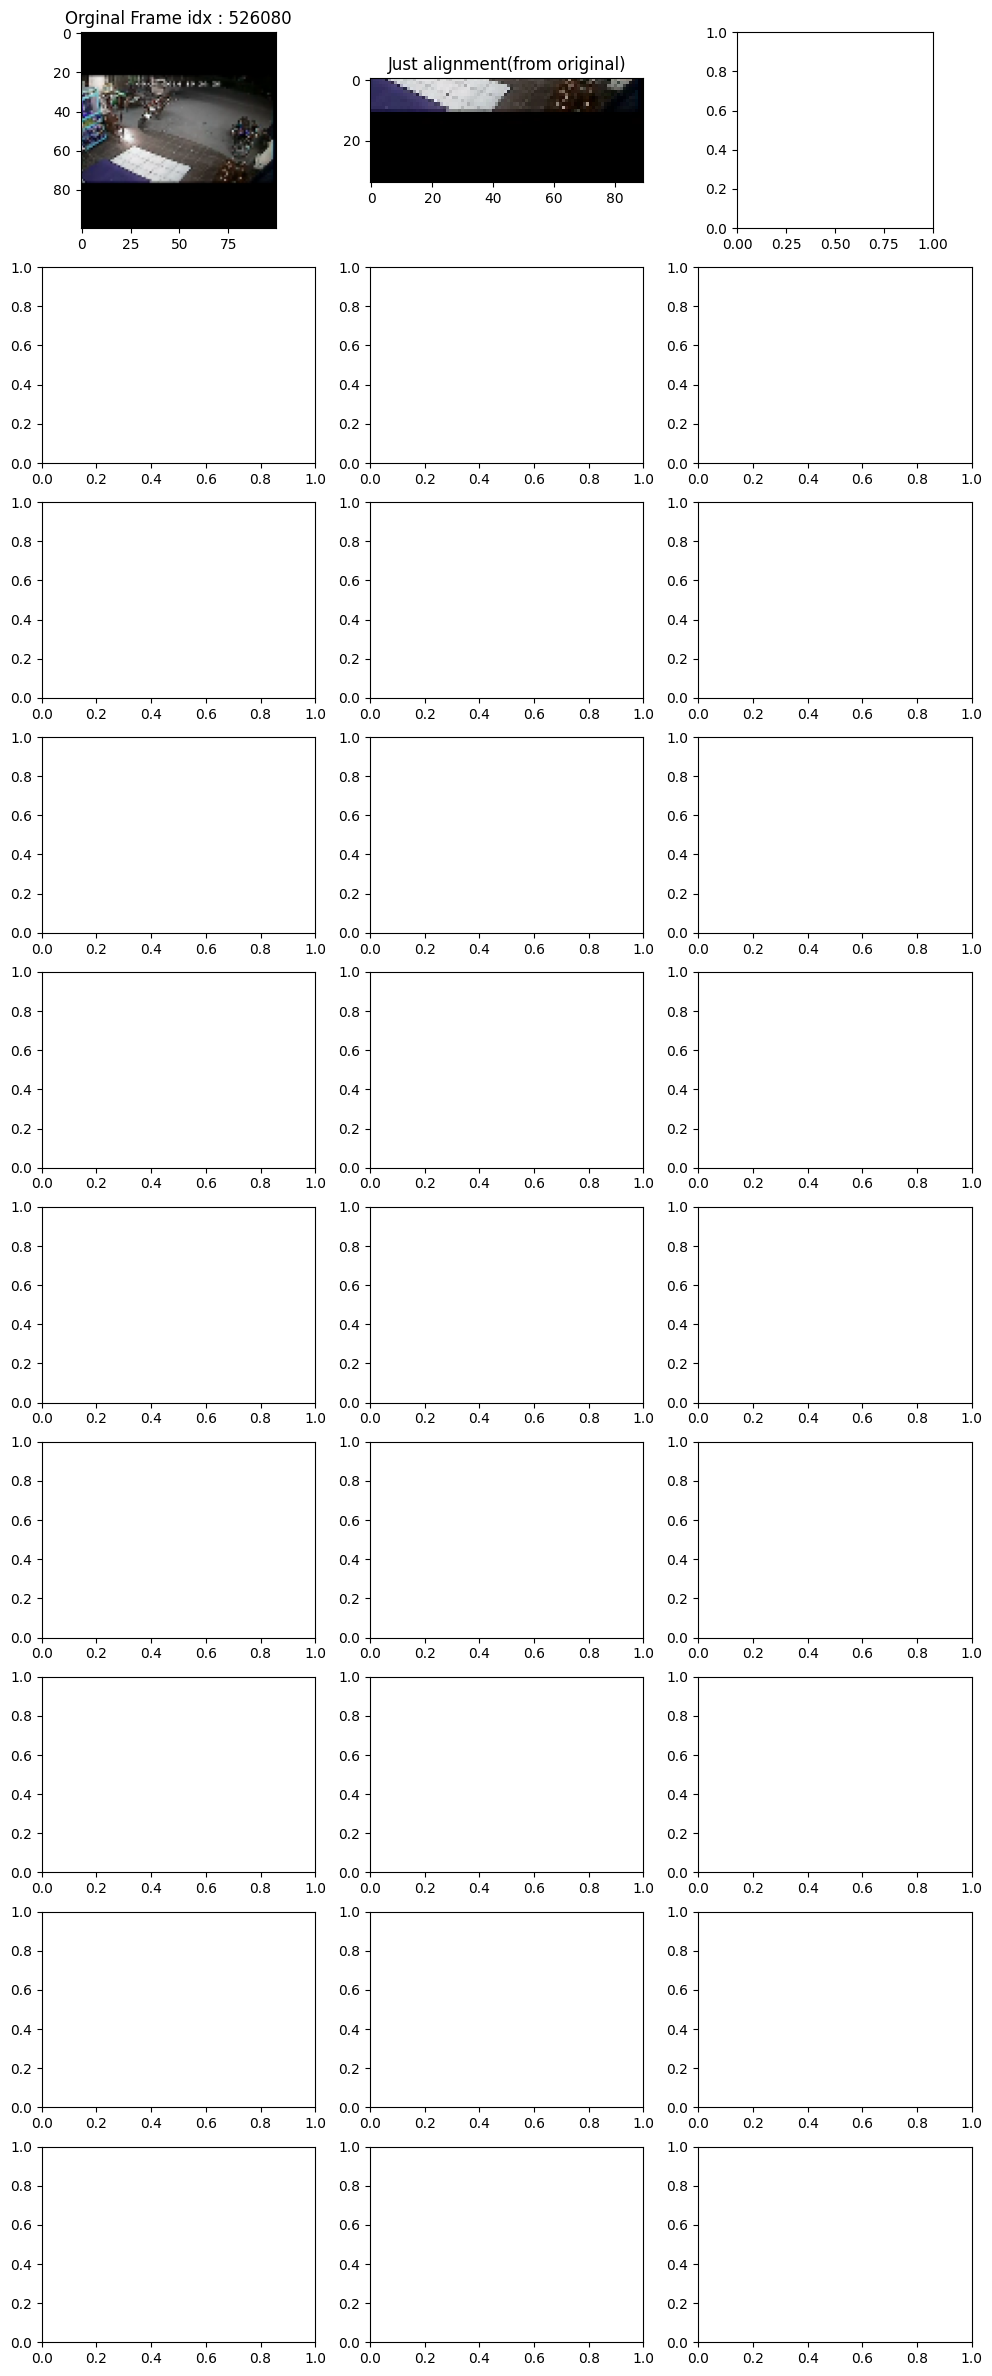

In [59]:
samplerandom(test,n_rows=10,height_expand=0.5,width_expand=0.5,img_resize=100)

In [ ]:
test[0]["extracted_frames"].shape


(240, 320, 3)

In [ ]:
plt.imshow(img[expanded_y_min:expanded_y_max , expanded_x_min:startcoord_x+expanded_x_max ])


[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:>]]


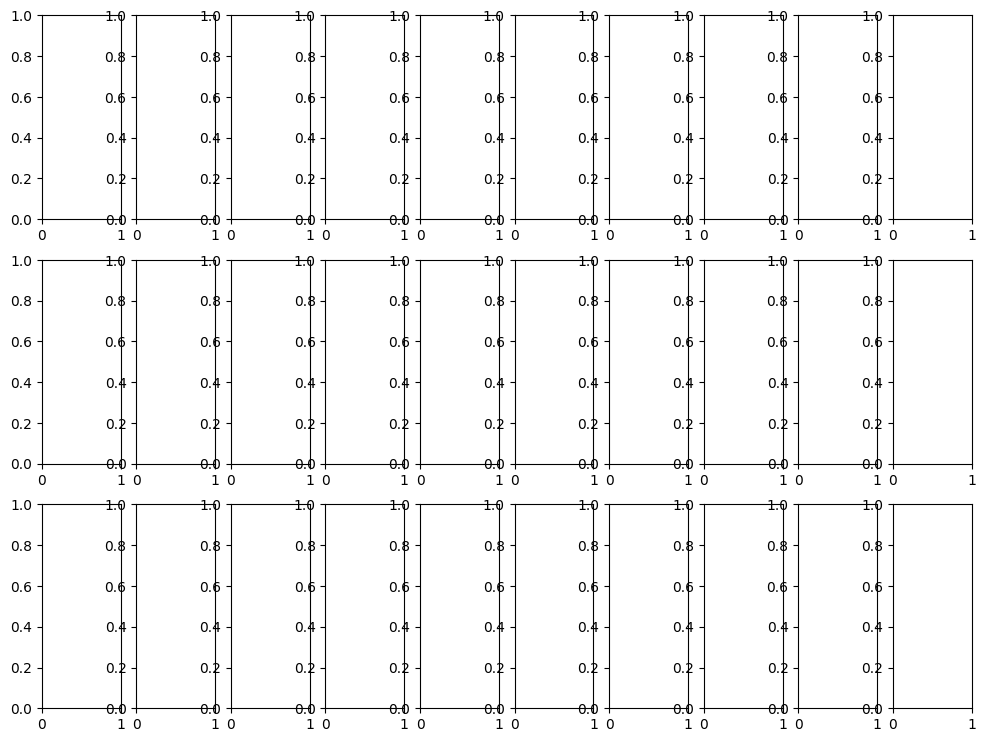

In [22]:
_, axs = plt.subplots(3, 10, figsize=(12, 3*3))
print(axs)

In [21]:
axs

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

In [275]:
samplerandom(test,300)

68
15.200000000000001
4.0
31


In [ ]:

idx = 693900
coords = test[idx]["coordinates"][len(test[idx]["coordinates"])//2]
rx = 224/240
ry = 224/320
x_values = coords[1::2]
y_values = coords[2::2]

startcoord_x = int(min(x_values))
startcoord_y = int(min(y_values))

print(startcoord_x)

x_values_ = coords[1::2]*ry
y_values_ = coords[1::2]*rx

endcoord_x = int(max(x_values))
endcoord_y = int(max(y_values))

startcoord_x_ = int(min(x_values_))
startcoord_y_ = int(min(y_values))



width = endcoord_x - startcoord_x
height = endcoord_y - startcoord_y_


# endcoord_x_ = int(max(x_values))
# endcoord_y_ = int(max(y_values))

expansion_width = 0.5 * width
expansion_height =1.3 * height

print(expansion_width)
print(expansion_height)

# expanded_x_min =  int(startcoord_x - expansion_width)
# expanded_y_min = int(startcoord_y- expansion_height)
# expanded_x_max = int(endcoord_x + expansion_width)
# expanded_y_max = int(endcoord_y + expansion_height)

expanded_x_min = int(max(0, startcoord_x_ - expansion_width))
expanded_y_min = int(max(0, startcoord_y_ - expansion_height))
expanded_x_max = int(min(endcoord_x + expansion_width, 224))
expanded_y_max = int(min(endcoord_y + expansion_height, 224))

print(expanded_x_min)
print(expanded_y_min)
print(expanded_x_max)
print(expanded_y_max)

img = test[idx]["extracted_frames"]
print(img.shape)
img = cv2.resize(img,(224,224))
print("Default no resize")
# plt.imshow(img)
# plt.imshow(img)
# plt.imsh
plt.imshow(img)
# plt.imshow(img[startcoord_y:startcoord_y+endcoord_y, startcoord_x:startcoord_x+endcoord_x])

After resizing, new coordinates


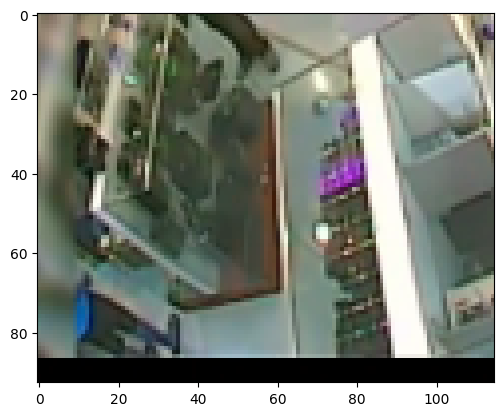

In [252]:
print("After resizing, new coordinates")
# resized_img = cv2.resize(img,(224,224))
# plt.imshow(resized_img)
plt.imshow(img[expanded_y_min:expanded_y_max , expanded_x_min:startcoord_x+expanded_x_max ])
# plt.imshow(img[startcoord_y_:startcoord_y_+endcoord_y_, startcoord_x_:startcoord_x_+endcoord_x_])

In [183]:
# train[0]["extracted_frames"]
plt.imshow(train[idx]["extracted_frames"][startcoord_y:startcoord_y+endcoord_y, startcoord_x:startcoord_x+endcoord_x])

NameError: name 'train' is not defined

In [ ]:
img_resize = cv2.resize()

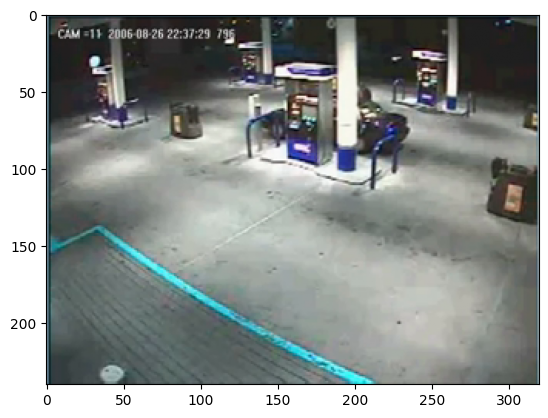

In [31]:
plt.imshow(train[idx]["extracted_frames"])

In [2]:
def collator_for_lists(batch):
    '''
    Reference : https://stackoverflow.com/questions/64883998/pytorch-dataloader-shows-odd-behavior-with-string-dataset
    Reference : https://stackoverflow.com/questions/52818145/why-pytorch-dataloader-behaves-differently-on-numpy-array-and-list
    '''
    # assert all('sentences' in x for x in batch)
    # assert all('label' in x for x in batch)
    
    a = {
        'id': [x['id'] for x in batch],
        'videos': [x['videos'] for x in batch],
        'persons': [x['persons'] for x in batch],
        'frames': torch.tensor(np.array([x['frames'] for x in batch])),
        'categories': torch.tensor(np.array([x['categories'] for x in batch])),
        'coordinates': torch.tensor(np.array([x['coordinates'] for x in batch])),
        # 'extracted_frames': torch.tensor([np.array(i["extracted_frames"]) for i in batch])
        # 'extracted_frames':torch.stack(list(map(lambda x: torch.tensor(x['extracted_frames']), batch))) 
        'extracted_frames':torch.stack(list(map(lambda x: extract_frames(x['id'],x['frames']), batch))) 
    }
    # logger.info(f"Total time to retrieve : {abs(start-time.time())}")
    return a
    

In [7]:
# # model = TubeletTemporalSpatialPart_concat_chan_2_Transformer(dataset="HRC", embed_dim_ratio=64, num_frames=20, num_classes=13, num_joints=17, in_chans=2, kernel=(8,3,3), stride=(8,3,3), mlp_ratio=2., qkv_bias=True, qk_scale=None, dropout=0.1, pad_mode = "constant",embed_dim_final=64,vit_model=None,include_top=True)

# f = TemporalTransformer( num_classes=13, num_frames=20, num_joints=17, in_chans=2, embed_dim=64, depth=4,
#                  num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
#                  drop_rate=0., attn_drop_rate=0., dropout=0.2)

num_classes 13
embed_dim 64
in_chans 2
num_joints 17


Creating vision transformer

In [45]:
# model_2 = VisionTransformer(image_size= 224,
#                 patch_size= 8,
#                 num_layers= 1,
#                 num_heads= 6,
#                 hidden_dim= 60,
#                 mlp_dim= 40,
#                 dropout=   0.0,
#                 attention_dropout=   0.0,
#                 num_classes=  64,
#             )

<h3> Implementing cross self attention block</h3>

In [19]:
# class CrossAttention(nn.Module):
#     def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., return_attention=True):
#         super().__init__()
#         self.num_heads = num_heads
#         head_dim = dim // num_heads
#         # NOTE scale factor can be manually set to be compatible with previous weights
#         self.scale = qk_scale or head_dim ** -0.5
#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.attn_drop = nn.Dropout(attn_drop)
#         self.proj = nn.Linear(dim, dim)
#         self.proj_drop = nn.Dropout(proj_drop)
#         self.cross_attn_scores = None

#         self.project_skeleton = nn.Linear(dim, dim)
#         self.project_context_key = nn.Linear(dim, dim)
#         self.project_context_value = nn.Linear(dim, dim)

#     def forward(self, encoder_1, encoder_2):
#         B, N, C = encoder_1.shape

#         q = self.project_skeleton(encoder_1).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
#         k = self.project_context_key(encoder_2).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
#         v = self.project_context_value(encoder_2).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

#         attn = (q @ k.transpose(-2, -1)) * self.scale
#         attn = attn.softmax(dim=-2)
#         attn = self.attn_drop(attn)

#         self.cross_attn_scores = attn

#         x = (attn @ v).transpose(1, 2).reshape(B, N, C)
#         x = self.proj(x)
#         x = self.proj_drop(x)

#         return x
    
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,return_attention=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor can be manually set to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.cross_attn_scores = None

        self.project_skeleton = nn.Linear(dim,dim)
        self.project_context_key = nn.Linear(dim,dim)
        self.project_context_value = nn.Linear(dim,dim)
        
    def forward(self, encoder_1,encoder_2): 
        #encoder_1 skeleton trajectories, encoder_2 visual information
        #value = output of model which contains skeleton trajectories, #query and key model which consists of spatial information
        # print(encoder_1.shape)
        # print(encoder_2.shape)
        B, N,C = encoder_1.shape #Batch, segment length, embed dim
        
        q, k, v = encoder_1, encoder_2, encoder_2   # make torchscript happy (cannot use tensor as tuple)
        #torch.Size([1, 100, 64])
        # print("block")
        # print("Input 1 ",encoder_1)
        # print("Input 2 ",encoder_2)
        q = self.project_skeleton(q).reshape(B,N,self.num_heads,C//self.num_heads).permute(0,2,1,3) #batch,segment length, num_heads,embed dim/num_head
        # project= self.project_skeleton(q)
        # print(q.size())

        k = self.project_context_key(k).reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3) #same
        v = self.project_context_value(v).reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3)
        # print(k)
        print(q.size())
        print(v.size())
        # print("reshapoed key ", k.size())
        # print(q.size())
        # B,N,C = encoder_2.shape
        # print(v.size())
        # v = v.squeeze()

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [100, 4, 21, 1]) [100, 4, segment legnth, 1 for each context]) 
        # print(q@k.transpose(-2,-1))
        attn = attn.softmax(dim=-2)
        # print(attn.size())
        print("attn")
        print(attn)
        attn = self.attn_drop(attn)

        self.cross_attn_scores = attn
        print((attn@v).size())
        x = (attn @ v).reshape(B, N, C)
        print(x.size())
            
        x = self.proj(x)
        print("Final input")
        print(x.size())

        x = self.proj_drop(x)

        return x

class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 dropout=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = CrossAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        #self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.dropout = nn.Dropout(dropout) #first try a simple dropout instead of drop path
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
    def forward(self, encoder_1,encoder_2):
        #architecture taken from these paper https://arxiv.org/pdf/2204.04564.pdf

        x = self.dropout(self.attn(encoder_1,encoder_2))
        print(encoder_2.size())
        # print(x.size())
        # print(x.permute(1,0,2).size())
        # x = self.norm2(encoder_2.permute(1,0,2)+x)
        x = self.mlp(x)
        return x
    


In [10]:
ca = nn.ModuleList([
    CrossAttentionBlock(
        dim=64, num_heads=8, mlp_ratio=4., qkv_bias=0, qk_scale=0,
        drop=0.3, attn_drop=0.7, dropout=0.2
        )
    for i in range(4)])

In [20]:
x = torch.rand(20,21,64)
y = torch.randn(20,1,64)
for i in ca:
    x = i(x,y)

torch.Size([20, 8, 21, 8])
torch.Size([20, 8, 1, 8])
attn
tensor([[[[0.0621],
          [0.0355],
          [0.0510],
          ...,
          [0.0516],
          [0.0418],
          [0.0452]],

         [[0.0513],
          [0.0481],
          [0.0463],
          ...,
          [0.0378],
          [0.0485],
          [0.0627]],

         [[0.0514],
          [0.0534],
          [0.0517],
          ...,
          [0.0551],
          [0.0459],
          [0.0419]],

         ...,

         [[0.0443],
          [0.0412],
          [0.0466],
          ...,
          [0.0491],
          [0.0489],
          [0.0413]],

         [[0.0467],
          [0.0412],
          [0.0441],
          ...,
          [0.0471],
          [0.0400],
          [0.0610]],

         [[0.0432],
          [0.0437],
          [0.0487],
          ...,
          [0.0592],
          [0.0380],
          [0.0491]]],


        [[[0.0427],
          [0.0465],
          [0.0465],
          ...,
          [0.0505],
        

In [27]:
ca[1].attn.cross_attn_scores[3]

TypeError: 'NoneType' object is not subscriptable

In [28]:
# ca(torch.randn(1,64),torch.randn(1,64))

To replace TemporalTransformer or anyother function -- forward function

- To do 
    - Create fusion models for all the types of model(should i?)

In [29]:
import torch.nn.functional as F

In [29]:
class FusionModel_TemporalTransformer(TemporalTransformer):
    def __init__(self,*args,fusion_type="early",cross_attention=True,**kwargs):
        # prin
        # print(True if fusion_type!="el" else False)

        if (fusion_type=="el") or (fusion_type=="l"):
            self.embed_fusion = kwargs["embed_dim"]//2
        else:
            self.embed_fusion = kwargs["embed_dim"] 
        self.fusion=fusion_type
        print(f"Fusion type : '{self.fusion}'")
        # self.embed_fusion = kwargs["embed_dim"] if (fusion_type!="el" or fusion_type!="l") else kwargs["embed_dim"]//2 #Embedding dimesnion is split so that, 64//2 -> 32 for ViT 32 for Temporal transformer

        kwargs["embed_dim"]= self.embed_fusion
        super().__init__(*args, **kwargs)
        
        self.model_2 = VisionTransformer(image_size= 224,
                patch_size= 8,
                num_layers= 1,
                num_heads= 6,
                hidden_dim= 60,
                mlp_dim= 40,
                dropout=   0.0,
                attention_dropout=   0.0,
                num_classes=  self.embed_fusion,
            )

        if (fusion_type=="el") or (fusion_type=="l") :
            self.head = nn.Linear(self.embed_fusion*2,kwargs["num_classes"])
        else:
            self.head = nn.Linear(self.embed_fusion,kwargs["num_classes"])

        self.need_crossattention = cross_attention
        if self.need_crossattention:
            self.cross_attention_block =  nn.ModuleList([CrossAttentionBlock(
              self.embed_fusion, num_heads=kwargs["num_heads"], mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 dropout=0., act_layer=nn.GELU
                 #drop_path=dpr[i] #first try a simple dropout instead of drop path
                )     for i in range(4)])
            
        print(f"Cross Attention Mode :- {self.need_crossattention}")
        # self.head = nn.Linear(self.embed_fusion if (fusion_type!="el") or (fusion_type!="l") else self.embed_fusion*2,kwargs["num_classes"])
        self.fusion_block = None #can be a nn.Sequential() to do the fusion.
        self.classification_block = None
        if self.fusion!=None:
            if self.fusion!="l":
                self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+2, kwargs["embed_dim"]))
            else:
                self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+1, kwargs["embed_dim"]))
        else:
            self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+1, kwargs["embed_dim"]))
        # self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+2, kwargs["embed_dim"])) if self.fusion!=None or self.fusion \
        #                                 else nn.Parameter(torch.zeros(kwargs["num_frames"]+1, kwargs["embed_dim"]))  
        self.model_2_output = None 
    def forward_features(self, x,image=None):
        #print("call forward features")
        # print(f"x shape: {x.shape}")

        x = self.embedding(x)

        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks

        x = torch.cat((cls_token, x), dim=1)

        # print(x.size())
        if self.fusion is not None:
            if self.fusion!="l": #early & early and late
                img = torch.permute(img,(1,0,2))
                x=torch.cat((x,img),dim=1)
        else:
            if self.need_crossattention:
                img = self.model_2(image).unsqueeze(0)
                self.model_2_output=img
    
        # print(x.size())
        #print(f"embedded x + cls_token shape: {x.shape}")

        #print(f"pos_embed shape: {self.pos_embed.shape}")
        #print(f"x + self.pos_embed shape: {(x + self.pos_embed).shape}")

        x = self.pos_drop(x + self.pos_embed)
        # print(f"pos_drop x shape: {x.shape}")

        #x = self.blocks(x)
        for blk in self.blocks:
            x = blk(x)
            #print(f"blocks(x) shape: {x.shape}")

        x = self.norm(x)
        # print()
        # print("x shape:", x.shape)
     
        # cls_token_final = x[:, 0]

        # print(cls_token_final.size())
        if self.need_crossattention:
            for i in self.cross_attention_block:
                # x = i(x,self.model_2_output)
                # x_reshaped = x.permute(1, 0, 2)  # Reshape to (N, B, C)
                # x_reshaped = x_reshaped.unsqueeze(1)  # Add a singleton dimension at dim=1
                # output_reshaped = self.model_2_output.permute(1, 0, 2)  # Reshape to (N, B, C)
                # print(x_reshaped.size())
                # print(output_reshaped.size())
                
                x = i(x, self.model_2.img_output)

        # else:
        
            
        cls_token_final = x[:, 0]
        # return self.pre_logits(x[:, 0])
        return cls_token_final

    def forward(self,x,image=None):
        if self.fusion=="e": #Early fusion temporal transformer
            x = self.forward_features(x,image)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            #do early fusion here
            return x
        if self.fusion=="el": #Early & late fusion transformer
            x = self.forward_features(x,image)
            # print(torch.permute(self.model_2_output,(1,0,2)).size())
            x = torch.concat([x,self.model_2_output.squeeze()],dim=1)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            return x

        if self.fusion=="l": #late fusion transformer
            x = self.forward_features(x,image)
            # print(x.size())
            x = torch.concat([x,self.model_2_output.squeeze()],dim=1)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            return x

        if self.fusion==None: #Regular temporal transformer
            x = self.forward_features(x,image)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            return x

In [29]:
# from transformer import FusionModel_TemporalTransformer

In [38]:
del a

In [30]:
a = FusionModel_TemporalTransformer(fusion_type=None,cross_attention=True,num_classes=19, num_frames=20, num_joints=17, in_chans=2, embed_dim=64, depth=4,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., dropout=0.2)

Fusion type : 'None'
num_classes 19
embed_dim 64
in_chans 2
num_joints 17
Cross Attention Mode :- True


In [31]:
a.cross_attention_block[1].attn.cross_attn_scores

In [35]:
a.cross_attention_block[0].attn.cross_attn_scores[1]

tensor([[[0.0456],
         [0.0465],
         [0.0480],
         [0.0464],
         [0.0464],
         [0.0487],
         [0.0493],
         [0.0453],
         [0.0476],
         [0.0468],
         [0.0480],
         [0.0468],
         [0.0490],
         [0.0498],
         [0.0510],
         [0.0486],
         [0.0458],
         [0.0469],
         [0.0476],
         [0.0485],
         [0.0472]],

        [[0.0464],
         [0.0459],
         [0.0473],
         [0.0502],
         [0.0486],
         [0.0469],
         [0.0441],
         [0.0467],
         [0.0490],
         [0.0478],
         [0.0484],
         [0.0468],
         [0.0504],
         [0.0459],
         [0.0474],
         [0.0488],
         [0.0464],
         [0.0482],
         [0.0491],
         [0.0466],
         [0.0491]],

        [[0.0473],
         [0.0501],
         [0.0473],
         [0.0472],
         [0.0472],
         [0.0464],
         [0.0476],
         [0.0473],
         [0.0479],
         [0.0505],
        

In [ ]:
))

In [34]:
a(torch.randn(20,20,34),torch.randn(20,3,224,224))

FusionModel_TemporalTransformer(
  (embedding): Linear(in_features=34, out_features=64, bias=True)
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=128, out_features=64, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
      

tensor([[-3.0292, -2.8639, -2.8469, -3.0827, -2.9578, -2.8286, -2.9140, -2.9291,
         -2.8132, -2.9763, -2.9169, -3.0218, -2.8822, -3.0040, -2.8842, -2.9942,
         -3.0057, -3.0083, -3.0418],
        [-3.0292, -2.8639, -2.8469, -3.0827, -2.9578, -2.8286, -2.9140, -2.9291,
         -2.8132, -2.9763, -2.9169, -3.0218, -2.8822, -3.0040, -2.8842, -2.9942,
         -3.0057, -3.0083, -3.0418],
        [-3.0292, -2.8639, -2.8469, -3.0827, -2.9578, -2.8286, -2.9140, -2.9291,
         -2.8132, -2.9763, -2.9169, -3.0218, -2.8822, -3.0040, -2.8842, -2.9942,
         -3.0057, -3.0083, -3.0418],
        [-3.0292, -2.8639, -2.8469, -3.0827, -2.9578, -2.8286, -2.9140, -2.9291,
         -2.8132, -2.9763, -2.9169, -3.0218, -2.8822, -3.0040, -2.8842, -2.9942,
         -3.0057, -3.0083, -3.0418],
        [-3.0292, -2.8639, -2.8469, -3.0827, -2.9578, -2.8286, -2.9140, -2.9291,
         -2.8132, -2.9763, -2.9169, -3.0218, -2.8822, -3.0040, -2.8842, -2.9942,
         -3.0057, -3.0083, -3.0418],
     

In [32]:
img = torch.randn(100,3,224,224)
coordinates= torch.Tensor(train[:100]["coordinates"])
print(coordinates.size())


AttributeError: 'list' object has no attribute 'split'

In [50]:
k = torch.randn(100,4,21,16)
i = torch.randn(100,4,16,1)

In [51]:
s = k@i

In [36]:
s.size()

torch.Size([100, 4, 21, 1])

In [32]:
(s@torch.randn(100,4,16,1).transpose(-2,-1)).size()

torch.Size([100, 4, 21, 16])

In [38]:
a(coordinates,img)

torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])


tensor([[-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        ...,
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210]],
       grad_fn=<LogSoftmaxBackward0>)

In [76]:
img = torch.randn(100,3,224,224)
coordinates= torch.Tensor(train[:100]["coordinates"])
print(coordinates.size())

torch.Size([100, 20, 34])


In [67]:
coordinates.size()

torch.Size([100, 20, 34])

Trying to get and visualize attention weights ViT PyTorch implementation

In [182]:
from torch.nn.functional import interpolate
import matplotlib.pyplot as plt

In [8]:
path ="/home/s2765918/code-et/results/HRC/temporal_earlyfusion_all_500_128vitdescriptor_crossattention_fix_2/models/temporal_earlyfusion_all_500_128vitdescriptor_crossattention_fix_2_fold_2.pt"

In [9]:
model_l= torch.load(path,map_location="cpu")

In [61]:
h = model_l.cross_attention_block[0].attn.cross_attn_scores

In [63]:
attention_weights = ((f -f.min()) / (f.max() -f.min()))

In [77]:
torch.argsort(attention_weights,descending=True,dim=0)

tensor([[ 0],
        [ 8],
        [ 1],
        [ 9],
        [ 5],
        [10],
        [ 6],
        [ 7],
        [ 2],
        [11],
        [12],
        [ 4],
        [ 3],
        [19],
        [20],
        [18],
        [14],
        [13],
        [17],
        [15],
        [16]])

In [ ]:
attention_weights

In [33]:
h.size()

torch.Size([1, 4, 21, 1])

In [62]:
f = h[0][2][:]

In [73]:
model_l.cross_attention_block[0].attn.cross_attn_scores[0][0][:].size()

torch.Size([21, 1])

In [74]:
torch.argsort(model_l.cross_attention_block[0].attn.cross_attn_scores[0][0][:],dim=0)

tensor([[13],
        [14],
        [11],
        [16],
        [15],
        [10],
        [17],
        [18],
        [ 4],
        [19],
        [ 5],
        [20],
        [ 8],
        [ 9],
        [12],
        [ 3],
        [ 7],
        [ 2],
        [ 6],
        [ 1],
        [ 0]])

In [50]:
from matplotlib.cm import ScalarMappable
import os
from PIL import Image, ImageColor

In [57]:
coordinates = torch.from_numpy(test_dataset[5]["coordinates"])
frames = test_dataset[0]["extracted_frames"]
model_l(coordinates.unsqueeze(0),test_dataset[5]["extracted_frames"])

tensor([[-35.2729, -46.2655, -47.2065, -39.7655, -41.8069, -34.7251, -50.4959,
         -38.2048, -26.0744, -42.6764, -51.9555,   0.0000, -42.8624]],
       grad_fn=<LogSoftmaxBackward0>)

(224, 224, 3)


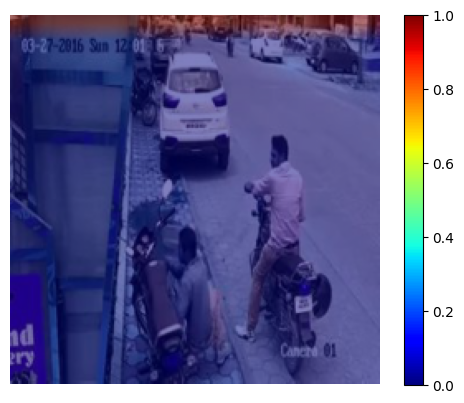

In [64]:
img = extract_frames(test_dataset[5]["path"],test_dataset[5]["frames"])
img_2 = Image.fromarray((img* 255).astype(np.uint8))

print(img.shape)
# test_,getattention = visualize_attention_weight(model,block_no,head)
colormap = plt.cm.get_cmap('jet')
# save_path = os.path.join(save_path,f"sample_{sample_idx}_block_no_{block_no}_head_{head}.png")
# Overlay the heatmap on the image
heatmap = colormap(attention_weights.detach().numpy())
heatmap = np.uint8(heatmap * 255)
heatmap = cv2.resize(heatmap, (224, 224))

# plt.imshow(img)
alpha=0.7
# plt.imshow(getattention.detach().numpy(), alpha=alpha)
plt.axis('off')

plt.imshow(img)

# Plot the heatmap as an overlay
plt.imshow(heatmap, alpha=0.5)

# Add colorbar to show the heatmap intensity scale
sm = ScalarMappable(cmap=colormap)
sm.set_array(attention_weights.detach().numpy())
cbar = plt.colorbar(sm)

# Show the plot
plt.axis('off')
# plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [44]:
def extract_frames(path,frame_list):

    cap = cv2.VideoCapture(path) 

    middle_frame = frame_list[len(frame_list)//2].item()
    
    cap.set(1,middle_frame) 

    ret, frame = cap.read()
    dim = (224,224)

    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

    # frame = rearrange(resized,"h w c -> c h w")
    return resized/255.0

In [109]:
from matplotlib.cm import ScalarMappable
import os
from PIL import Image, ImageColor


In [317]:
def visualize_attention_weight(model,block_no,head):


    getBlock = model.blocks[block_no]
    attn = getBlock.attn.attn_scores

    getHead =attn[0,head,:,:]
    # print(getHead.size())
    # getHead=  torch.mean(attn,dim=).squeeze()
    # print(attn.size())
    # print(getHead.size())
    # print(getHead_.size())
    # attention.view(1, 1, 28, 28), (224, 224),
    # getHead = interpolate(getHead.view(1, 1, 22, 22),size=(224, 224) ,mode='nearest', align_corners=None, recompute_scale_factor=None, antialias=False).view(224, 224, 1)
    attention_weights = ((getHead -getHead.min()) / (getHead.max() -getHead.min())).detach().numpy()
    # F.interpolate(attention.view(1, 1, 28, 28), (224, 224), mode='bilinear').view(224, 224, 1)# plt.imshow(getHead.detach().numpy())
    return getHead,attention_weights

In [318]:
def visualze_attention_img(model,block_no,head,sample_idx,dataset=None,save_path="/home/s2765918/code-et/code/attention_visualize"): 
    img = extract_frames(dataset[sample_idx]["path"],dataset[sample_idx]["frames"])
    img_2 = Image.fromarray((img* 255).astype(np.uint8))

    print(img.shape)
    test_,getattention = visualize_attention_weight(model,block_no,head)
    colormap = plt.cm.get_cmap('jet')
    save_path = os.path.join(save_path,f"sample_{sample_idx}_block_no_{block_no}_head_{head}.png")
    # Overlay the heatmap on the image
    heatmap = colormap(getattention)
    heatmap = np.uint8(heatmap * 255)
    heatmap = cv2.resize(heatmap, (224, 224))

    # plt.imshow(img)
    alpha=0.7
    # plt.imshow(getattention.detach().numpy(), alpha=alpha)
    plt.axis('off')

    plt.imshow(img)
    
    # Plot the heatmap as an overlay
    plt.imshow(heatmap, alpha=0.5)
    
    # Add colorbar to show the heatmap intensity scale
    sm = ScalarMappable(cmap=colormap)
    sm.set_array(getattention)
    cbar = plt.colorbar(sm)

    # Show the plot
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    plt.close()


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
tensor([[ 1,  9, 11,  8,  7,  3,  0,  2, 12,  4,  5,  6, 10]])
(224, 224, 3)


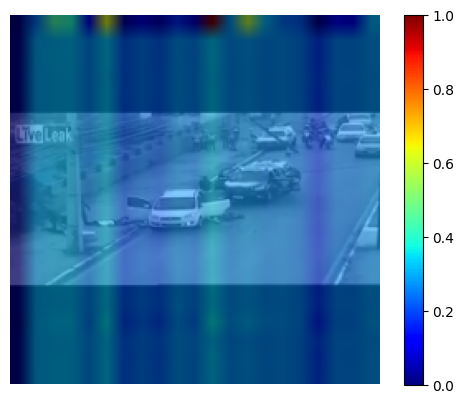


KeyboardInterrupt



In [319]:
sample_idx = 86000
block_no =  0
head =3

# print(test[sample_idx]["categories"])
coordinates,extracte = test_dataset[sample_idx]["coordinates"],test[sample_idx]
print(test_dataset[sample_idx]['categories'])
coordinates= torch.from_numpy(coordinates).unsqueeze(0)
extracte= torch.tensor(extracte).unsqueeze(0)
# print(model_l(coordinates,extracte))

print(torch.argsort(model_l(coordinates,extracte), dim=- 1, descending=True))
g = visualze_attention_img(model=model_l,block_no = block_no,head =head,sample_idx=sample_idx,dataset=test_dataset)
# save_path= "/home/s2765918/code-et/code/attention_visualize"
save_path = os.path.join(save_path,f"sample_{sample_idx}_block_no_{block_no}_head_{head}.png")
plt.savefig(save_path, bbox_inches='tight')
# plt.close()

In [142]:
model_l(coordinates,test[0]["extracted_frames"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [204]:
test_dataset.categories[10000]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10])

In [ ]:
g = visualze_attention_img(model=model_l,block_no = 1,head =4,sample_idx=1)

In [ ]:
model_l.blocks[0].attn.attn_scores.size()

torch.Size([1, 8, 22, 22])

In [ ]:
model_l = torch.load(path,map_location="cpu")

In [22]:
coordinates,extracte = test_dataset[0]["coordinates"],test_dataset[0]["extracted_frames"]

In [ ]:
cv2.imread(test[1]["path"])

In [ ]:
print(cv2.imread(test[1]["path"]))

None


In [ ]:
print(cv2.imread(test[1]["path"]))

None


In [ ]:
import cv2

TypeError: Invalid shape () for image data

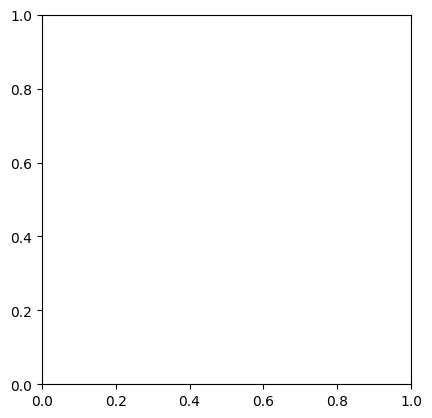

In [ ]:
plt.imshow(np.array(cv2.imread(test[1]["path"]),dtype=np.float32))

In [ ]:
test[0]["extracted_frames"].size()

torch.Size([768])

In [ ]:
coordinates= torch.tensor(coordinates).unsqueeze(0)
extracte= extracte.unsqueeze(0)

In [ ]:
extracte = extracte.squeeze(0)

In [ ]:
model_l.blocks[0].attn.attn_scores.size()

torch.Size([1, 8, 22, 22])

In [ ]:
model_l(torch.tensor(coordinates),extracte)

/tmp/ipykernel_3734260/4122853855.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_l(torch.tensor(coordinates),extracte)


tensor([[-1.5542e+01, -1.6151e+01, -1.8020e+01, -1.5214e+01, -1.1946e+01,
         -1.7779e+01, -1.9013e+01, -1.6037e+01, -1.0133e-05, -1.5910e+01,
         -1.3965e+01, -1.3094e+01, -1.6380e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
model_l.blocks[0].attn.attn_scores.size()

torch.Size([312, 8, 22, 22])

In [ ]:
attention = model_l

<h4>Visualizing images</h4>

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size = 100, shuffle=True, collate_fn=collator_for_lists,num_workers=24,pin_memory=True,persistent_workers=True)


In [ ]:
data_test = next(iter(train_dataloader))
coordinates, frames = data_test["coordinates"],data_test["extracted_frames"]
frames_test = frames.permute(0,3,1,2) 

In [ ]:
frames_test.size()

torch.Size([1, 3, 224, 224])

In [ ]:
model_l(coordinates,frames_test)

torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])


tensor([[-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        ...,
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210]],
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
coordinates.size()

torch.Size([1, 20, 34])

In [ ]:
model_l(coordinates,frames_test)

torch.Size([100, 4, 21, 1])


tensor([[-8.4659e+00, -1.0426e+01, -1.5241e+01,  ..., -1.1698e-02,
         -9.8242e+00, -8.2425e+00],
        [-5.4020e+00, -6.8446e+00, -5.5186e+00,  ..., -5.3354e+00,
         -7.3955e+00, -3.0865e+00],
        [-1.9955e+00, -5.3131e+00, -4.7221e+00,  ..., -4.9422e+00,
         -9.4851e+00, -4.0214e+00],
        ...,
        [-6.0807e+00, -9.4037e+00, -4.9908e+00,  ..., -6.5065e+00,
         -4.4945e-01, -9.4815e+00],
        [-6.2258e+00, -9.1342e+00, -5.6422e+00,  ..., -8.2234e+00,
         -5.5142e+00, -9.4864e+00],
        [-5.9454e+00, -7.9641e+00, -1.3932e+01,  ..., -9.0896e-03,
         -1.0773e+01, -6.7574e+00]], grad_fn=<LogSoftmaxBackward0>)

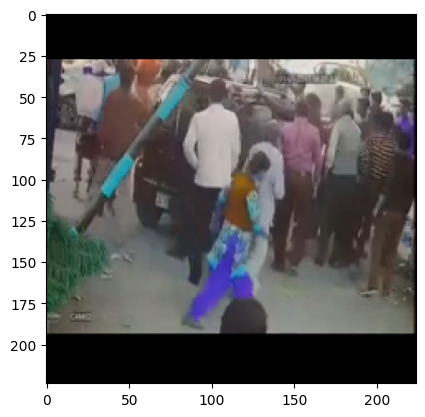

In [ ]:
plt.imshow(frames.squeeze().numpy())

with skeleton

In [ ]:
att_mat = model_l.blocks[0].attn.attn_scores

torch.Size([100, 8, 21, 21])

In [ ]:
from torch.nn.functional import interpolate

att_mat = interpolate(att_mat, size=224 ,mode='nearest', align_corners=None, recompute_scale_factor=None, antialias=False)

In [ ]:
att_mat.size()

torch.Size([1, 34, 224])

with ViT

In [ ]:
torch.softmax(model_l.cross_attention_block.attn.cross_attn_scores,dim=1)

tensor([[[[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]]],


        [[[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],

In [ ]:
# att_mat = torch.mean(torch.s
# tack([model_l.model_2.encoder.layers.encoder_layer_0.attention_weight]).squeeze(1), dim=1)
att_mat = model_l.model_2.encoder.layers.encoder_layer_0.attention_weight

In [ ]:
img_idx = 47

In [ ]:
w,h = 28,28

In [ ]:
att_mat_0 = att_mat[img_idx].detach()

In [ ]:
att_mat_0 = torch.mean(att_mat_0[:,1:,1:],dim=0)

In [ ]:
att_mat_0 = att_mat_0[2,:]

torch.Size([784])

In [ ]:
attention = att_mat_0[1,1,1:]

IndexError: too many indices for tensor of dimension 1

In [ ]:
attention = att_mat_0.reshape(28,28)

In [ ]:
def show_img2(img1, img2, alpha=0.5):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

In [ ]:
attention = F.interpolate(attention.view(1, 1, 28, 28), (224, 224), mode='bilinear').view(224, 224, 1)

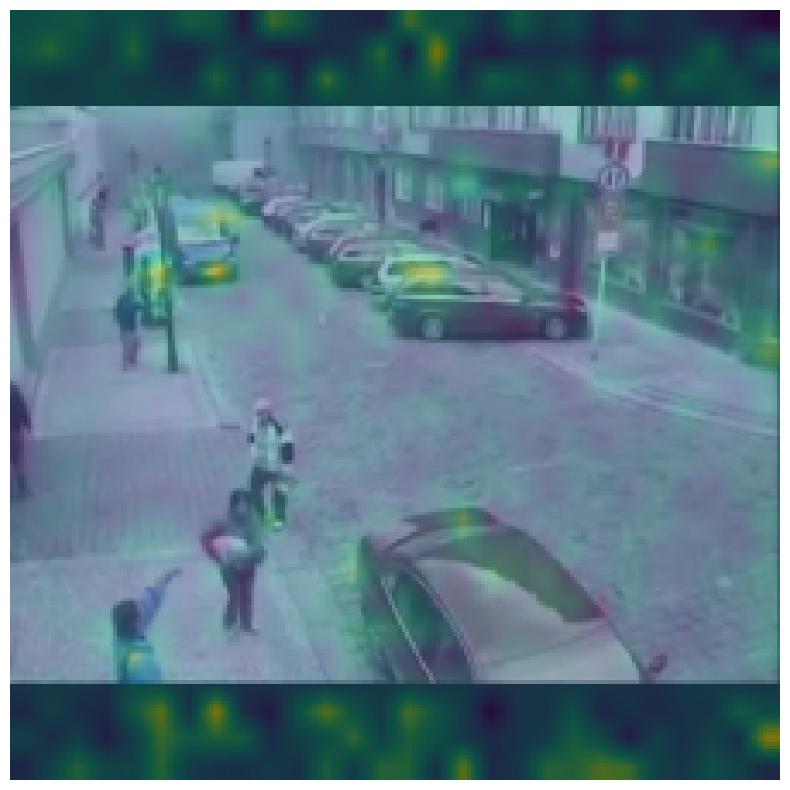

In [ ]:
show_img2(frames[img_idx],attention)

In [ ]:
filter = attention.reshape(28, 28)

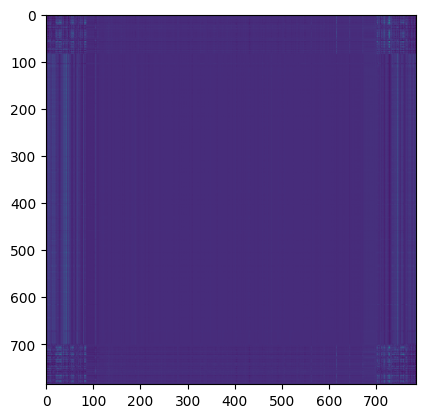

In [ ]:
plt.imshow(att_mat_0[3])

https://www.cs.utexas.edu/~gdurrett/courses/sp2023/sample-research.pdf diufferent represntation

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageColor

In [ ]:
def overlay_attention_weights(image_path, attention_weights, save_path):
    # Load the image
    # print(type(image_path))
    # print(image_path[])
    # img_array = image_path[0]
  
    image =  Image.fromarray((image_path[0] * 255).numpy().astype(np.uint8))
    
    # Choose one image's attention weights
    attention = attention_weights[0]  # Choose the first image
    
    # Reshape attention weights to match the spatial dimensions of the image
    resized_attention = attention.reshape(image.size[::-1])
    
    # Normalize attention weights between 0 and 1
    normalized_weights = (resized_attention - np.min(resized_attention)) / (np.max(resized_attention) - np.min(resized_attention))
    
    # Convert normalized weights to heatmap image
    heatmap = ImageColor.colormap("hot")(normalized_weights.flatten(), bytes=True)
    heatmap = Image.fromarray(heatmap, mode="RGB")
    heatmap = heatmap.resize(image.size, resample=Image.BICUBIC)
    
    # Blend the heatmap with the original image
    blended_image = Image.blend(image.convert("RGBA"), heatmap.convert("RGBA"), alpha=0.5)
    
    # Save or display the resulting image
    blended_image.save(save_path)
    blended_image.show()

In [ ]:
frames[0].shape[::-1]

torch.Size([3, 224, 224])

In [ ]:
torch.mean(attention[0],dim=0).size()

torch.Size([21, 1])

In [ ]:
print(torch.mean(attention[0],dim=0)[0])

tensor([1.], grad_fn=<SelectBackward0>)


In [ ]:
overlay_attention_weights(frames,attention,"/")

RuntimeError: shape '[224, 224]' is invalid for input of size 84

In [ ]:
c = torch.randn(224,224,3).numpy()

In [ ]:
Image.fromarray((frames[0]*255).numpy())

TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [ ]:
im = Image.fromarray((frames[0] * 255).numpy().astype(np.uint8))

In [ ]:
def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


In [ ]:
visualize_attention(a,torch.randn(3,224,224),16,'cpu')

AttributeError: 'ViT' object has no attribute 'get_last_selfattention'

In [ ]:
a = ViT(224,16,12,30,2,8,40)

In [ ]:
a(torch.randn(1,3,224,224))

torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])


tensor([[-0.9491,  0.9033, -0.1284, -0.6549,  0.0174, -0.2677,  0.6118, -0.1467,
         -0.1112,  0.7255, -0.1893,  0.4106]], grad_fn=<AddmmBackward0>)

In [ ]:
class ModifiedMultiHead(MultiheadAttention):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    def forward(self,)

In [ ]:
vit_model = VisionTransformer(image_size= 224,
                patch_size= 16,
                num_layers= 4,
                num_heads= 3,
                hidden_dim= 120,
                mlp_dim= 40,
                dropout=   0.0,
                attention_dropout=   0.0,
                num_classes=  64,
            )

In [ ]:
print(vit_model.encoder)

Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((120,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (ln_2): LayerNorm((120,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=120, out_features=40, bias=True)
        (1): GELU(approximate=none)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=40, out_features=120, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((120,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
      )
      (dro

In [ ]:
vit_model.encoder.layers.encoder_layer_0

NameError: name 'vit_model' is not defined

In [ ]:
plt.imshow()

In [ ]:
model.blocks[0].attn.attn_scores[0,:,:].shape

torch.Size([8, 6, 6])

In [ ]:
count = 0
for i in range(3):
    count+=model.blocks[0].attn.attn_scores.shape[1]

In [ ]:
model.Torso_blocks[0].attn.attn_scores.shape

torch.Size([10, 8, 2, 2])

In [ ]:
len(model.blocks)

4

In [ ]:
print(count)

24


In [ ]:
attns = []
for i in range(4):
    attns.append(model.blocks[i].attn.attn_scores)
attns = torch.concat(attns)

In [ ]:
model.blocks[0].attn.attn_scores.shape

In [ ]:
torch.mean(attns,axis=1)

In [ ]:
attns[-1].

In [ ]:
model.blocks[0].attn.attn_scores

In [ ]:
# train_crime_trajectories_1 = {}
# train_crime_trajectories_1["Robbery034_0101"] = train_crime_trajectories["Robbery034_0101"]

In [ ]:
# train_crime_trajectories["Robbery014_0127"].coordinates.shape

In [ ]:
import cv2
import glob
import os
# images = [cv2.imread(image, 0) for image in glob.glob("*.png")]

# result = cv2.bitwise_and(images[0], images[1])
# for image in images[2:]:
#     result = cv2.bitwise_and(result, image)

# cv2.imshow('result', result)
# cv2.waitKey(0)

In [ ]:
import seaborn as sns

In [ ]:
path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos"

In [ ]:
all_classes = os.listdir(path)

In [ ]:
x = []
y = []
for i in range(len(all_classes)):
    x.append(all_classes[i])
    y.append(len(os.listdir(os.path.join(path,all_classes[i]))))


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# sns.to("Total number of video per classes")
sns.set_style("whitegrid")

sns.barplot(y,x).set(title="Total number of videos per classes")
plt.savefig("no_videos_p_class.png",dpi=350)

In [ ]:
import numpy as np

In [ ]:
trajectories_path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/dataverse_files/trajectories_all/"

In [ ]:
x = []
y = []
trajectory_p_video = []
for i in all_classes:
    full_path = os.path.join(trajectories_path,i) #accessing trajectory/classname
    peoples = os.listdir(full_path)
    for people in peoples:
        if not people.startswith('.'):

            people_path = os.path.join(full_path,people)
            trajectory_p_video.append(len(os.listdir(people_path)))
            # for trajectory in os.listdir(people_path):
            #         full_trajectory_path = os.path.join(people_path,trajectory)
            #         data = np.loadtxt(full_trajectory_path, delimiter=',',ndmin=2)
            #         # data = np.array(sorted(data,key=lambda x:x[0]))
            #         len_trajectory = data.shape[0]
            #         # if len_trajectory>1851:
            #         #     print(len_trajectory)
            #         #     print(i,people,trajectory)
            #         x.append(i)
            #         y.append(len_trajectory)



In [ ]:
# sns.title("Trajectory per video")
sns.boxplot(y=trajectory_p_video,width=0.09).set(title="Trajectory Per Video")
plt.savefig("trajectory_p_video.png",dpi=300)

In [ ]:
            # for trajectory in os.listdir(people_path):
            #         full_trajectory_path = os.path.join(people_path,trajectory)
            #         data = np.loadtxt(full_trajectory_path, delimiter=',',ndmin=2)
            #         # data = np.array(sorted(data,key=lambda x:x[0]))
            #         len_trajectory = data.shape[0]
            #         # if len_trajectory>1851:
            #         #     print(len_trajectory)
            #         #     print(i,people,trajectory)
            #         x.append(i)
            #         y.append(len_trajectory)



In [ ]:
max(y)

In [ ]:
sns.boxplot(y,x)

In [ ]:
ids = dataset[12509]["id"]

In [ ]:
getVideoFiles = ids[0]

videoDir =  getVideoFiles.split("_")[0][:-3] 

videofile = getVideoFiles.split("_")[0]+"_x264.mp4"

video_path = os.path.join(path,videoDir,videofile)

In [ ]:
print(video_path)